In [1]:
import torch
import data_loader
import evaluation
import train 
import model

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
datasets, tokens_vocab, y_vocab = data_loader.load(['train', 'dev'], S=100)
datasets['train']

Samples: 742 (no_sense: 0)
Sentences: 100 (N=76)
Vocab:
	Tokens:1662
	Senses:889

In [3]:
lr=1e-3
dropout = 0.2
D=300
batch_size=100
num_epochs=5

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr, betas=(0.9, 0.999))

losses, train_acc, val_acc = train.train(
    m, optimizer, datasets['train'], datasets['dev'], num_epochs=num_epochs, batch_size=batch_size)

[4] loss: 50.657: 100%|██████████| 8/8 [00:01<00:00,  7.31it/s]


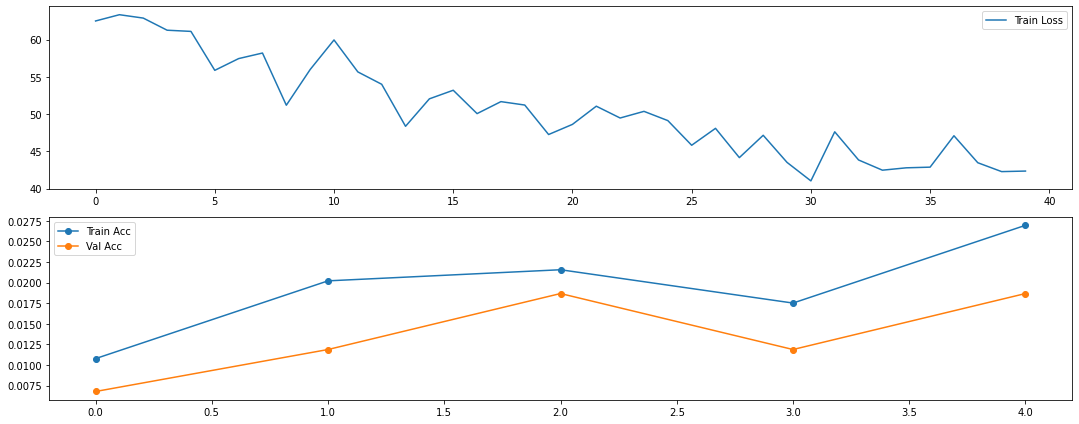

In [4]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [8]:
pd.set_option('max_rows', 20)
eval_df.groupby('query_token').agg({
    'query': 'count',
    'y_true': 'nunique'
}).sort_values(by='y_true')[-5:]

,query,y_true
query_token,,
men,3,3
system,4,4
put,4,4
be,6,4
was,12,4


In [5]:
import pandas as pd
import numpy as np

pd.set_option('max_columns', 100)

acc, eval_df, attention_df = evaluation.evaluate_verbose(m, datasets['train'], tokens_vocab, y_vocab, iter_lim=None)
idxs = np.where(eval_df['y_true'] == eval_df['y_pred'])
# idxs = np.where(eval_df['query_token'] == 'great')
idxs = list(idxs[0][:20])
ev_styled, att_styled = evaluation.fancy_display(eval_df, attention_df, idxs)
ev_styled

## Open Issues
* Self Attention
* Check W matrices init - normal works horribly worse than kaiming
* Check no_sense - ~75% of the samples - running without it
* Check $\sqrt{D}$ factor - speeds up convergence significantly
* Check gather

,query,y_true
query_token,,
discussion,1,1
doing,1,1
does,1,1
eager,1,1
doble,1,1
doctrine,1,1
edges,1,1
earthquake,1,1
divan,1,1
